In [2]:
import cv2 
import glob
import os 
import numpy as np
from google.colab.patches import cv2_imshow
import json
import sqlite3
import pandas as pd
from pprint import pprint
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import matplotlib.pyplot as plt
from numpy import asarray
import keras
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import tensorflow as tf 
import tensorflow.keras.backend as K
from tensorflow.keras import Input,Sequential, initializers, optimizers, callbacks, layers, models
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, ReLU, Conv2D,MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import sqlite3
seed = 47
BATCH_SIZE=120
IMAGE_SIZE = (224,224)

In [3]:
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [4]:
def plot_result(history, title):
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="train loss")
    ax[0].plot(history.history['val_loss'], color='r', label="val loss",axes=ax[0])
    legend = ax[0].legend()

    ax[1].plot(history.history['accuracy'], color='b', label="train acc")
    ax[1].plot(history.history['val_accuracy'], color='r',label="val acc")
    legend = ax[1].legend()
    ax[0].set_title(title)
    plt.plot()

In [5]:
def show_layers(model):
    print('Name\tOutput shape\tActivation\tInitializer')
    for l in model.layers:
        print('{0}({1})\t{2}\t{3}\t{4}'
            .format(l.name,
              l.__class__.__name__,
              l.output_shape,
              l.activation.__name__ if hasattr(l, 'activation') else '<none>',
              l.kernel_initializer.__class__.__name__ if hasattr(l, 'kernel_initializer') else '<none>'))


def custom_summary(model):
    model.summary()
    show_layers(model)

In [ ]:
inputFolder = '/content/drive/MyDrive/technodataset/img'
os.mkdir('/content/drive/MyDrive/technodataset/Resizedimg')

total_images = 50008
i = 0

for img in glob.glob(inputFolder + "/*.jpg"):
    image = cv2.imread(img)
    if image is not None :
        imgResized = cv2.resize(image,(224,224))
    pathimage = "/content/drive/MyDrive/technodataset/Resizedimg" + img[40:]
    cv2.imwrite(pathimage,imgResized)
    i += 1
    if i % int(total_images * 0.1) == 0:
      print("Resizing image {}/{} ({:.2f}%)".format(i, total_images, (i/total_images)*100))

cv2.destroyAllWindows()

In [ ]:
inputFolder = '/content/drive/MyDrive/technodataset/Resizedimg'
os.mkdir('/content/drive/MyDrive/technodataset/Normimg')
i=0
total_images = 50007
for img in glob.glob(inputFolder + "/*.jpg"):
    images = cv2.imread(img)
    norm_img = np.zeros((224,224))
    final_img = cv2.normalize(images, norm_img , 0 ,1, cv2.NORM_MINMAX)
    pathimage = "/content/drive/MyDrive/technodataset/Normimg" + img[47:]
    cv2.imwrite(pathimage,final_img )
    i+=1
    if i % int(total_images * 0.1) == 0:
      print("Normalizing image {}/{} ({:.2f}%)".format(i, total_images, (i/total_images)*100))
    
cv2.destroyAllWindows

In [6]:
conn = sqlite3.connect("/content/drive/MyDrive/metadata.sqlite")

df = pd.read_sql_query("""SELECT json_extract(data, '$.BIN_FCSKU_DATA') AS data,
                        json_extract(data, '$.EXPECTED_QUANTITY') AS qnty,
                        img_id AS img_id
                        FROM metadata
                        ORDER BY img_id;
                        """, conn)
print(df['img_id'])
df.data = df.data.apply(json.loads)
y=df['qnty'].to_numpy()


0        00005
1        00008
2        00013
3        00015
4        00022
         ...  
49995    99930
49996    99939
49997    99952
49998    99979
49999    99999
Name: img_id, Length: 50000, dtype: object


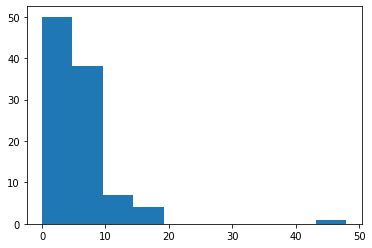

In [7]:
uniq = np.unique(y[:5000])
hist, bins = np.histogram(y[:100], bins=40)
plt.hist(y[:100])
#plt.xlim(0, 50)
plt.show()


In [8]:
y = y[:5000]
df = df[:5000]
#y = np.delete(y, np.where(y == 48))

In [9]:
np.unique(y)
len(df)

5000

In [10]:
unique, counts = np.unique(y, return_counts=True)
for i in range(len(unique)) :
  if counts[i] == 1 :
    index = np.where(y == unique[i])
    df = df.drop(index[0].tolist(), axis=0)
    y = np.delete(y, index)
#df = df.drop(53,axis=0)   

In [11]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 35, 37])

In [12]:
len(y)

4991

In [ ]:
images=list()
i=0
total_images = 49977
for img_id in df['img_id'] :
  path = '/content/drive/MyDrive/technodataset/Resizedimg/' +str(img_id) + '.jpg' 
  image = cv2.imread(path)
  images.append(image.tolist())
  i+=1
  if i % int(total_images * 0.1) == 0:
    print("Processing image {}/{} ({:.2f}%)".format(i, total_images, (i/total_images)*100))

In [ ]:
df['img_id']

0      00005
2      00013
4      00022
5      00024
6      00048
       ...  
195    01920
196    01921
197    01928
198    01963
199    01973
Name: img_id, Length: 196, dtype: object

In [ ]:
len(images)

196

In [ ]:
nb = np.max(y)+1
Y = keras.utils.to_categorical(y, num_classes=nb)
X_train, X_test, y_train, y_test  = train_test_split(images, Y, test_size=0.1,stratify=Y)
X_train ,X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,stratify=y_train)

In [ ]:
len(X_train)

140

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[[[ 97 111 129]
  [100 114 132]
  [ 99 112 128]
  ...
  [108 164 193]
  [106 162 191]
  [104 160 189]]

 [[ 95 109 127]
  [ 98 112 130]
  [ 99 112 128]
  ...
  [106 162 191]
  [105 160 191]
  [106 162 191]]

 [[ 97 111 129]
  [ 98 112 130]
  [ 99 112 128]
  ...
  [101 155 186]
  [102 155 188]
  [104 158 189]]

 ...

 [[ 47  55  68]
  [ 46  54  67]
  [ 41  49  62]
  ...
  [ 85  96 110]
  [ 85  96 110]
  [ 85  96 110]]

 [[ 81  87 100]
  [ 80  86  99]
  [ 86  94 107]
  ...
  [ 85  96 110]
  [ 85  96 110]
  [ 85  96 110]]

 [[101 107 120]
  [104 110 123]
  [ 99 107 120]
  ...
  [ 84  95 109]
  [ 84  95 109]
  [ 84  95 109]]]


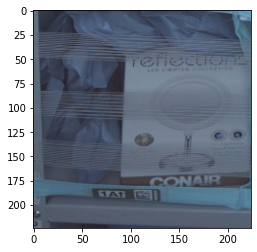

In [ ]:
plt.imshow(X_test[1])
print(y_test[1])
print(X_test[1])

In [ ]:
X_train1 = []
for x in X_train :
  X_train1.append(x.tolist())

In [ ]:
type(X_train1[0])

list

In [ ]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(np.array(X_train).astype(np.float32)/255.0*2-1,
                                     y_train,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     seed=seed)
steps_per_epoch= round(np.array(X_train).shape[0] / BATCH_SIZE)

In [ ]:
train_generator

In [ ]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(np.array(X_train).astype(np.float32)/255.0*2-1,
                                     y_train,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     seed=seed)
steps_per_epoch= round(np.array(X_train).shape[0] / BATCH_SIZE)
#del X_train,y_train
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(np.array(X_val).astype(np.float32)/255.0*2-1,
                                 y_val,
                                 batch_size=BATCH_SIZE,
                                 shuffle=False,
                                 seed=seed)
#del X_val,y_val

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(np.array(X_test).astype(np.float32)/255.0*2-1,
                                   y_test,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   seed=seed)
#del X_test,y_test

metrics = ['accuracy', f1, AUC(name='auc')]

<ipython-input-23-c808a70ce789>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_generator = val_datagen.flow(np.array(X_val).astype(np.float32)/255.0*2-1,


ValueError: ignored

In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model = InceptionV3(input_shape=(224,224,3),include_top=True, weights=None,classes=18)

Epoch 1/10
1/1 [==============================] - 26s 26s/step - loss: 3.3178 - accuracy: 0.1000 - f1: 0.0000e+00 - auc: 0.4390 - val_loss: 2.8899 - val_accuracy: 0.0278 - val_f1: 0.0000e+00 - val_auc: 0.5294
Epoch 2/10
1/1 [==============================] - 89s 89s/step - loss: 2.8455 - accuracy: 0.0667 - f1: 0.0000e+00 - auc: 0.6415 - val_loss: 2.8893 - val_accuracy: 0.0278 - val_f1: 0.0000e+00 - val_auc: 0.5441
Epoch 3/10
1/1 [==============================] - 66s 66s/step - loss: 2.8392 - accuracy: 0.0667 - f1: 0.0000e+00 - auc: 0.6360 - val_loss: 2.8888 - val_accuracy: 0.0278 - val_f1: 0.0000e+00 - val_auc: 0.6185
Epoch 4/10
1/1 [==============================] - 14s 14s/step - loss: 3.2150 - accuracy: 0.0500 - f1: 0.0000e+00 - auc: 0.4928 - val_loss: 2.8882 - val_accuracy: 0.0278 - val_f1: 0.0000e+00 - val_auc: 0.5882
Epoch 5/10
1/1 [==============================] - 14s 14s/step - loss: 3.2140 - accuracy: 0.0500 - f1: 0.0000e+00 - auc: 0.4551 - val_loss: 2.8877 - val_accuracy: 0

<ipython-input-52-4e1c6a6d0fc8>:14: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_acc = model.evaluate_generator(test_generator)[1]


Results at the end of training: acc=10.00%, test_acc=5.00%


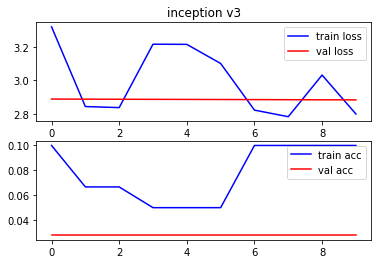

In [ ]:
from timeit import default_timer as timer
model = Sequential()
model.add(base_model)
model.compile(loss=CategoricalCrossentropy(),optimizer=SGD(learning_rate=0.0005),metrics=metrics)

start_time = timer()    
history = model.fit(train_generator,validation_data=val_generator,epochs=10,steps_per_epoch=steps_per_epoch)
end_time = timer()
    
custom_summary(model)
print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))
    
acc=history.history['accuracy'][-1]
test_acc = model.evaluate_generator(test_generator)[1]
    
print('Results at the end of training: acc={0:.02f}%, test_acc={1:.02f}%'.format(acc*100, test_acc*100))

plot_result(history,"inception v3")


In [ ]:
import seaborn as sns
ypred = model.predict(test_generator)
ypred = np.argmax(ypred, axis=1)
ytest = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(ytest, ypred)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.show()